In [ ]:
using Pkg
Pkg.activate("./")
Pkg.instantiate()

In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using PythonCall
sacc = pyimport("sacc");

In [3]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path_wlwl = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/wlwl.yml"
yaml_path_gcgc = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/gcgc.yml"
yaml_path_3x2 = "/home/jaimerz/PhD/LimberJack.jl/data/DESY1/gcgc_gcwl_wlwl.yml"

sacc_wlwl = sacc.Sacc().load_fits(sacc_path)
sacc_gcgc = sacc.Sacc().load_fits(sacc_path)
sacc_3x2 = sacc.Sacc().load_fits(sacc_path)
yaml_wlwl = YAML.load_file(yaml_path_wlwl)
yaml_gcgc = YAML.load_file(yaml_path_gcgc)
yaml_3x2 = YAML.load_file(yaml_path_3x2) 

meta_wlwl, files_wlwl = make_data(sacc_wlwl, yaml_wlwl)
meta_gcgc, files_gcgc = make_data(sacc_gcgc, yaml_gcgc)
meta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2)

DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24
DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESw

(LimberJack.Instructions(["DESgc__0", "DESgc__1", "DESgc__2", "DESgc__3", "DESgc__4", "DESwl__0", "DESwl__1", "DESwl__2", "DESwl__3"], Any[["DESgc__0", "DESgc__0"], ["DESgc__1", "DESgc__1"], ["DESgc__2", "DESgc__2"], ["DESgc__3", "DESgc__3"], ["DESgc__4", "DESgc__4"], ["DESgc__0", "DESwl__0"], ["DESgc__0", "DESwl__1"], ["DESgc__0", "DESwl__2"], ["DESgc__0", "DESwl__3"], ["DESgc__1", "DESwl__0"]  …  ["DESwl__0", "DESwl__0"], ["DESwl__0", "DESwl__1"], ["DESwl__0", "DESwl__2"], ["DESwl__0", "DESwl__3"], ["DESwl__1", "DESwl__1"], ["DESwl__1", "DESwl__2"], ["DESwl__1", "DESwl__3"], ["DESwl__2", "DESwl__2"], ["DESwl__2", "DESwl__3"], ["DESwl__3", "DESwl__3"]], ["galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_density", "galaxy_shear", "galaxy_shear", "galaxy_shear", "galaxy_shear"], [0, 5, 13, 23, 34, 47, 52, 57, 62, 67  …  259, 283, 307, 331, 355, 379, 403, 427, 451, 475], [0.00019024248750512107, 7.391276663994371e-5, 4.261252890607883e-5, 2.22965965139283e-5

In [4]:
"""
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
sacc_gcgc = sacc.Sacc().load_fits(sacc_path)
sacc_wlwl = sacc.Sacc().load_fits(sacc_path)
sacc_3x2 = sacc.Sacc().load_fits(sacc_path)
yaml_gcgc = YAML.load_file("data/DESY1/gcgc.yml")
yaml_wlwl = YAML.load_file("data/DESY1/wlwl.yml")
yaml_3x2 = YAML.load_file("data/DESY1/gcgc_gcwl_wlwl.yml")
meta_wlwl, files_wlwl = make_data(sacc_wlwl, yaml_wlwl)   
println("Loaded wlwl")   
meta_gcgc, files_gcgc = make_data(sacc_gcgc, yaml_gcgc)
println("Loaded gcgc")
meta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2)
println("Loaded 3x2")
"""

"sacc_path = \"/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits\"\nsacc_gcgc = sacc.Sacc().load_fits(sacc_path)\nsacc_wlwl = sacc.Sacc().load_fits(sacc_path)\nsacc_3x2 = sacc.Sacc().load_fits(sacc_path)\nyaml_gcgc = YAML.load_file(\"data/DESY1/gcgc.yml\")\nyaml_wlwl = YAML" ⋯ 60 bytes ⋯ "\"data/DESY1/gcgc_gcwl_wlwl.yml\")\nmeta_wlwl, files_wlwl = make_data(sacc_wlwl, yaml_wlwl)   \nprintln(\"Loaded wlwl\")   \nmeta_gcgc, files_gcgc = make_data(sacc_gcgc, yaml_gcgc)\nprintln(\"Loaded gcgc\")\nmeta_3x2, files_3x2 = make_data(sacc_3x2, yaml_3x2)\nprintln(\"Loaded 3x2\")\n"

In [5]:
function model_wlwl(x; meta=meta_wlwl, files=files_wlwl)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, h=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    nuisances = Dict("DESwl__0_dz" => x[1],
                     "DESwl__1_dz" => x[2],
                     "DESwl__2_dz" => x[3],
                     "DESwl__3_dz" => x[4])
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

function model_gcgc(x; meta=meta_gcgc, files=files_gcgc)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, f=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    DESgc__0_b = 1.9
    DESgc__1_b = 1.9
    DESgc__2_b = 1.9
    DESgc__3_b = 1.9
    DESgc__4_b = 1.9 
    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESgc__0_dz" => x[1],
                     "DESgc__1_dz" => x[2],
                     "DESgc__2_dz" => x[3],
                     "DESgc__3_dz" => x[4],
                     "DESgc__4_dz" => x[5])
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

function model_3x2(x; meta=meta_3x2, files=files_3x2)
    cosmo = Cosmology(Ωm=0.3, Ωb=0.05, h=0.67, σ8=0.81, ns=0.96,
    tk_mode=:EisHu, pk_mode=:Halofit)
    DESgc__0_b = 1.9
    DESgc__1_b = 1.9
    DESgc__2_b = 1.9
    DESgc__3_b = 1.9
    DESgc__4_b = 1.9 
    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESwl__0_dz" => x[1],
                     "DESwl__1_dz" => x[2],
                     "DESwl__2_dz" => x[3],
                     "DESwl__3_dz" => x[4],
                     "DESgc__0_dz" => x[5],
                     "DESgc__1_dz" => x[6],
                     "DESgc__2_dz" => x[7],
                     "DESgc__3_dz" => x[8],
                     "DESgc__4_dz" => x[9])
    cosmo.settings.cosmo_type = eltype(valtype(x))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [65]:
function make_Cmod(dz_cov, data_cov, model; mode="AD")
    m = size(dz_cov)[1]
    n_cls = size(data_cov)[1]
    T = zeros(n_cls, m)

    if mode == "AD"
        println("Using automatic differentiation to compute T")
        null = zeros(n)
        T = ForwardDiff.jacobian(model, null)
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        for i in 1:m
            null = zeros(m)
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(null.+e) .- model(null.-e)) ./ (2*d)
        end
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(data_cov + TPT)
    return Cmod
end

make_Cmod (generic function with 1 method)

In [66]:
dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

dz_cov_wlwl = diagm(dz_err_wlwl.^2)
dz_cov_gcgc = diagm(dz_err_gcgc.^2)
dz_cov_3x2 = diagm(dz_err_3x2.^2);

In [67]:
Cmod_wlwl = make_Cmod(dz_cov_wlwl, meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_gcgc = make_Cmod(dz_cov_gcgc, meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_3x2 = make_Cmod(dz_cov_3x2, meta_3x2.cov, model_3x2; mode="FD");

Using finite differences to compute T
Using finite differences to compute T
Using finite differences to compute T


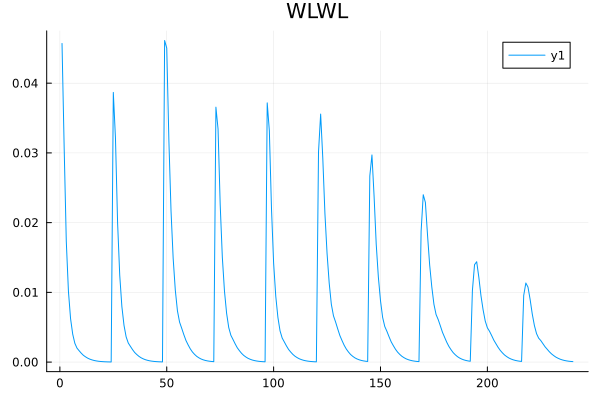

In [68]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl)) ./ diag(meta_wlwl.cov), title="WLWL")

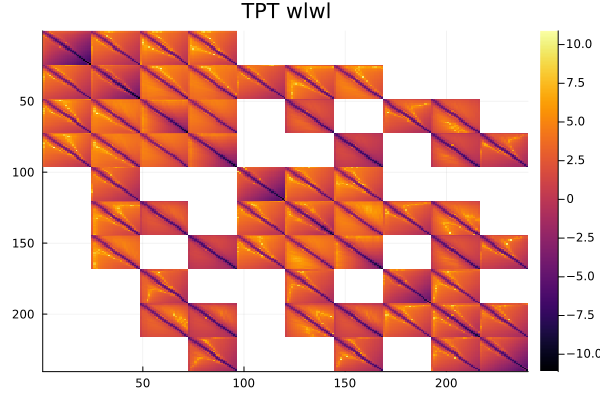

In [69]:
heatmap(log.(abs.((Cmod_wlwl .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

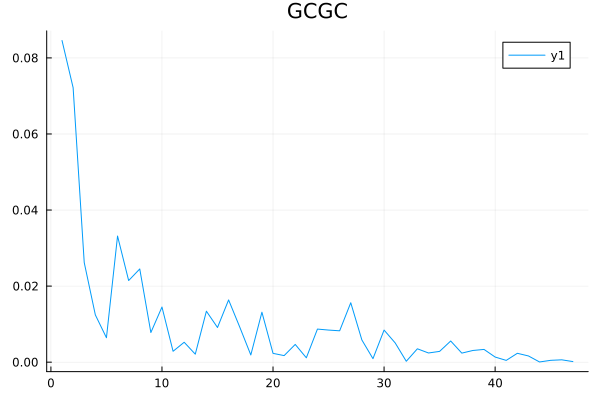

In [70]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc)) ./ diag(meta_gcgc.cov), title="GCGC")

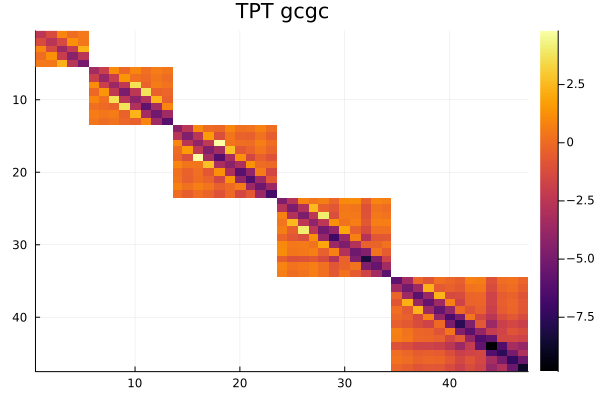

In [71]:
heatmap(log.(abs.((Cmod_gcgc .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

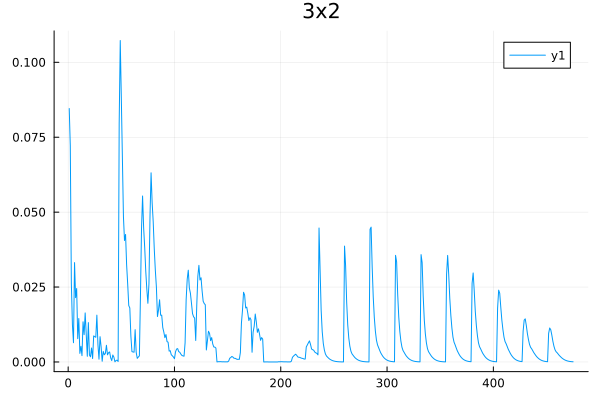

In [72]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2)) ./ diag(meta_3x2.cov), title="3x2")

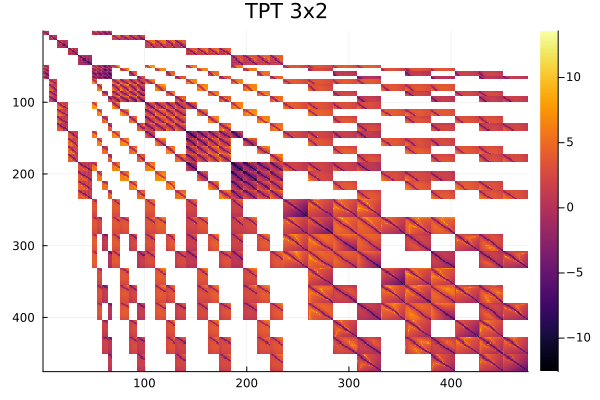

In [73]:
heatmap(log.(abs.((Cmod_3x2 .- meta_3x2.cov)./ meta_3x2.cov)), title="TPT 3x2", yflip=true)

In [15]:
npzwrite("../../data/DESY1/nzs/wlwl_dz_cov_marg.npz",
        Dict("cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

LoadError: UndefVarError: `C_mod` not defined

In [ ]:
C_mod = make_Cmod_Nz(cov_k0, cov_k1, cov_k2, cov_k3; cosmo=cosmo)
inv_C_mod = inv(C_mod);

In [ ]:
plot(abs.(diag(wlwl_meta.cov) .- diag(C_mod)) ./ diag(wlwl_meta.cov), label="cosmo1", title="Nz - abs(C'-C) / C")

In [ ]:
npzwrite("../../data/DESY1/nzs/wlwl_nz_cov_marg.npz",
        Dict("cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices gcgc

In [ ]:
function model_cov_dz_gc(x; meta=gcgc_meta, files=gcgc_files, cosmo=cosmo) 
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_b" => 1.49,
                     "DESgc__1_b" => 1.81,
                     "DESgc__2_b" => 1.79,
                     "DESgc__3_b" => 2.18,
                     "DESgc__4_b" => 2.24,
                     "DESgc__0_dz" => x[1],
                     "DESgc__1_dz" => x[2],
                     "DESgc__2_dz" => x[3],
                     "DESgc__3_dz" => x[4],
                     "DESgc__4_dz" => x[5])    
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [ ]:
function model_cov_nz_gc(DESgc__0_nz, DESgc__1_nz, DESgc__2_nz, DESgc__3_nz, DESgc__4_nz;
                      meta=gcgc_meta, files=gcgc_files, cosmo=cosmo) 
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_b" => 1.49,
                     "DESgc__1_b" => 1.81,
                     "DESgc__2_b" => 1.79,
                     "DESgc__3_b" => 2.18,
                     "DESgc__4_b" => 2.24,   
                     "DESgc__0_nz" => DESgc__0_nz,
                     "DESgc__1_nz" => DESgc__1_nz,
                     "DESgc__2_nz" => DESgc__2_nz,
                     "DESgc__3_nz" => DESgc__3_nz,
                     "DESgc__4_nz" => DESgc__4_nz)  
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [ ]:
function make_Cmod_dz_gc(dz_cov; cosmo=cosmo, meta=gcgc_meta)
    d = 0.00005
    n_cls = 47
    m  = 5
    T = zeros(n_cls, m)
    for i in 1:m
        dz = zeros(m)
        e = zeros(m)
        e[i] = d
        T[:, i] = (model_cov_dz_gc(dz.+e; cosmo=cosmo) .- model_cov_dz_gc(dz.-e; cosmo=cosmo)) ./ (2*d)
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(meta.cov + TPT)
    return Cmod
end

In [ ]:
function make_Cmod_Nz_gc(cov_k0, cov_k1, cov_k2, cov_k3, cov_k4; cosmo=cosmo, meta=gcgc_meta)
    d = 0.005
    n_cls = 47
    m  = length(nz_0)
    println(m)
    T0 = zeros(n_cls, m)
    T1 = zeros(n_cls, m)
    T2 = zeros(n_cls, m)
    T3 = zeros(n_cls, m)
    T4 = zeros(n_cls, m)

    for i in 1:m
        e = zeros(m)
        e[i] = d
        T0[:, i] = (model_cov_nz_gc(nz_0.+e, nz_1, nz_2, nz_3, nz_4; cosmo=cosmo) .- model_cov_nz_gc(nz_0.-e, nz_1, nz_2, nz_3, nz_4; cosmo=cosmo)) ./ (2*d)
        T1[:, i] = (model_cov_nz_gc(nz_0, nz_1.+e, nz_2, nz_3, nz_4; cosmo=cosmo) .- model_cov_nz_gc(nz_0, nz_1.-e, nz_2, nz_3, nz_4; cosmo=cosmo)) ./ (2*d)
        T2[:, i] = (model_cov_nz_gc(nz_0, nz_1, nz_2.+e, nz_3, nz_4; cosmo=cosmo) .- model_cov_nz_gc(nz_0, nz_1, nz_2.-e, nz_3, nz_4; cosmo=cosmo)) ./ (2*d)
        T3[:, i] = (model_cov_nz_gc(nz_0, nz_1, nz_2, nz_3.+e, nz_4; cosmo=cosmo) .- model_cov_nz_gc(nz_0, nz_1, nz_2, nz_3.-e, nz_4; cosmo=cosmo)) ./ (2*d)
        T4[:, i] = (model_cov_nz_gc(nz_0, nz_1, nz_2, nz_3, nz_4.+e; cosmo=cosmo) .- model_cov_nz_gc(nz_0, nz_1, nz_2, nz_3, nz_4.+e; cosmo=cosmo)) ./ (2*d)
    end
    TT0 = T0 * (cov_k0) * T0'
    TT1 = T1 * (cov_k1) * T1'
    TT2 = T2 * (cov_k2) * T2'
    TT3 = T3 * (cov_k3) * T3'
    TT4 = T4 * (cov_k4) * T4';
    Cmod = Symmetric(meta.cov + TT0 + TT1 + TT2 + TT3 + TT4)
    return Cmod
end

In [ ]:
nz_0 = pyconvert(Vector{Float64}, nz_DESgc__0["dndz"])
nz_1 = pyconvert(Vector{Float64}, nz_DESgc__1["dndz"])
nz_2 = pyconvert(Vector{Float64}, nz_DESgc__2["dndz"])
nz_3 = pyconvert(Vector{Float64}, nz_DESgc__3["dndz"])
nz_4 = pyconvert(Vector{Float64}, nz_DESgc__4["dndz"]);

In [ ]:
cov_k0 = pyconvert(Vector{Vector{Float64}}, nz_DESgc__0["cov"])
cov_k0 = Diagonal(permutedims(hcat(cov_k0...)))

cov_k1 = pyconvert(Vector{Vector{Float64}}, nz_DESgc__1["cov"])
cov_k1 = Diagonal(permutedims(hcat(cov_k1...)))

cov_k2 = pyconvert(Vector{Vector{Float64}}, nz_DESgc__2["cov"])
cov_k2 = Diagonal(permutedims(hcat(cov_k2...)))
    
cov_k3 = pyconvert(Vector{Vector{Float64}}, nz_DESgc__3["cov"])
cov_k3 = Diagonal(permutedims(hcat(cov_k3...)))

cov_k4 = pyconvert(Vector{Vector{Float64}}, nz_DESgc__4["cov"])
cov_k4 = Diagonal(permutedims(hcat(cov_k4...)));

In [ ]:
cosmo = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                  tk_mode="EisHu", 
                  Pk_mode="Halofit");

In [ ]:
dz_cov = [0.007^2 0 0 0 0; 
          0 0.007^2 0 0 0;
          0 0 0.006^2 0 0;
          0 0 0 0.010^2 0;
          0 0 0 0 0.010^2]
C_mod = make_Cmod_dz_gc(dz_cov; cosmo=cosmo)
inv_C_mod = inv(C_mod);

In [ ]:
plot(abs.(diag(gcgc_meta.cov) .- diag(C_mod)) ./ diag(gcgc_meta.cov), label="cosmo1", title="dz --- abs(C'-C) / C")
plot!([5, 13, 23, 34, 47], [0, 0, 0, 0, 0], seriestype=:scatter)


In [ ]:
npzwrite("../../data/DESY1/nzs/gcgc_dz_cov_marg.npz",
        Dict("cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

In [ ]:
C_mod = make_Cmod_Nz_gc(cov_k0, cov_k1, cov_k2, cov_k3, cov_k4; cosmo=cosmo)
inv_C_mod = inv(C_mod);

In [ ]:
plot(abs.(diag(gcgc_meta.cov) .- diag(C_mod)) ./ diag(gcgc_meta.cov), label="cosmo1", title="Nz - abs(C'-C) / C")
plot!([5, 13, 23, 34, 47], [0, 0, 0, 0, 0], seriestype=:scatter)


In [ ]:
npzwrite("../../data/DESY1/nzs/gcgc_nz_cov_marg.npz",
        Dict("cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))